In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import acquire
import prepare
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Data Wrangling:
### Data acquisiton

I want to identify variables that may contribute to churn and implement either the decision tree, random forest, or k nearest neighbor machine learning model to help predict which customers will churn.

first I need to acquire the data from the database.

In [2]:
#the following functions are already defined in the acquire.py file

def new_telco_data():
   
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

def get_telco_data():
    
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df
df = acquire.get_telco_data()

In [160]:
#chekcing the data information to identify potential problems early
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

### Data Prep
The 'total_charges' column is showing as an object, but it needs to be a numeric value. 

When attempting to convert the value to a float, I discovered that 11 rows had ' ' entered as a value. Since this is a small number compared to the dataset as a whole the cleanest solution is to conver those values to "NaN" and then drop them

In [3]:
#dropping 'blanks' from the total_charges column
df['total_charges'] = df["total_charges"].replace(' ', np.nan).astype(float)
df = df.dropna()


In [4]:
# removing protect class info from dataframe.
df = df.drop(columns=['gender','senior_citizen','partner','dependents'])

In [5]:
# the following function is already defined in the prepare.py file
def prep_telco(df):
    df = df.drop(columns=['payment_type_id','internet_service_type_id','contract_type_id','customer_id'])
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.churn)
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train.churn)
    return(train,validate,test)

#splitting the data to prevent data leakage from currupting any models
train,validate,test,dummy_list = prepare.prep_telco(df)

In [6]:
train.info()
dummy_list

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 4218 non-null   int64  
 1   phone_service                          4218 non-null   object 
 2   multiple_lines                         4218 non-null   object 
 3   online_security                        4218 non-null   object 
 4   online_backup                          4218 non-null   object 
 5   device_protection                      4218 non-null   object 
 6   tech_support                           4218 non-null   object 
 7   streaming_tv                           4218 non-null   object 
 8   streaming_movies                       4218 non-null   object 
 9   paperless_billing                      4218 non-null   object 
 10  monthly_charges                        4218 non-null   float64
 11  t

['paperless_billing',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'phone_service',
 'tech_support',
 'contract_type',
 'internet_service_type',
 'payment_type']

### Data Exploration
I will be exploring different variables and try to narrow the focus of what my ML algorithm will have to work through.

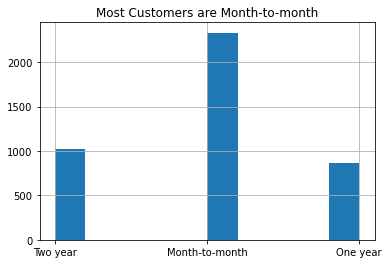

In [10]:
#most customers are getting the opportunity to churn monthly
plt.title('Most Customers are Month-to-month')
train.contract_type.hist()
plt.show()

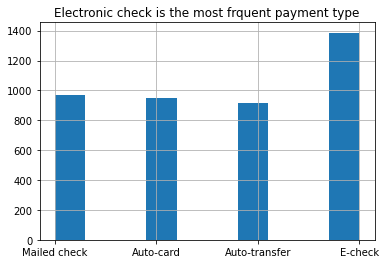

In [11]:
plt.title('Electronic check is the most frquent payment type')
train.payment_type.hist()
plt.xticks([0,1,2,3],['Mailed check','Auto-card','Auto-transfer','E-check'])
plt.show()

In [12]:
# checking to see if streaming services are connected
pd.crosstab(train.streaming_tv,train.streaming_movies)

streaming_movies,No,No internet service,Yes
streaming_tv,,,
No,1196,0,471
No internet service,0,930,0
Yes,445,0,1176


In [13]:
# checking to see if paperless billing correlates with churn
pd.crosstab(train.paperless_billing, train.churn)

churn,No,Yes
paperless_billing,,
No,1445,288
Yes,1652,833


In [14]:
# checking which payment method has the most churn
pd.crosstab(train.churn, train.payment_type)
# E-check has the most churn

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,756,797,761,783
Yes,159,154,625,183


In [15]:
# checking which contract type churns most
pd.crosstab(train.churn, train.contract_type)
# month to month has the most churn by far

contract_type,Month-to-month,One year,Two year
churn,,,
No,1339,771,987
Yes,992,98,31


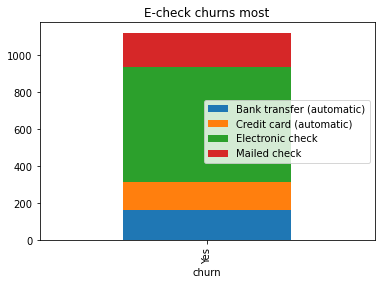

In [16]:
payment_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.payment_type)
payment_ct.plot(kind='bar', stacked = True)
plt.title('E-check churns most')
plt.legend()

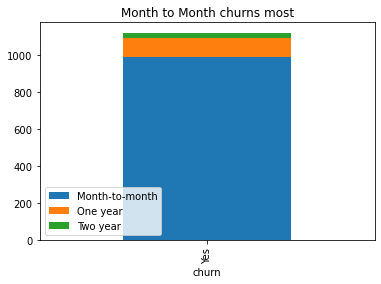

In [17]:
contract_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.contract_type)
contract_ct.plot(kind='bar', stacked = True)
plt.title('Month to Month churns most')
plt.legend()

In [18]:
# the most common payment/contract combo is E-check/month-to-month
pd.crosstab(train.payment_type,train.contract_type)

contract_type,Month-to-month,One year,Two year
payment_type,,,
Bank transfer (automatic),354,240,321
Credit card (automatic),347,240,364
Electronic check,1085,202,99
Mailed check,545,187,234


<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

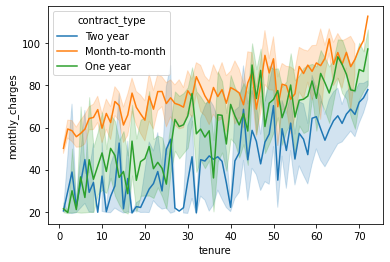

In [19]:
# monthly charges over tenure by payment_types
sns.lineplot(data=train, y='monthly_charges',x='tenure',hue='contract_type')

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

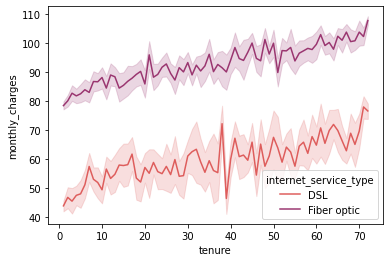

In [20]:
# monthly charges over tenure by internet service types
sns.lineplot(data=train.where(train.internet_service_type!='None'), y='monthly_charges',x='tenure',hue='internet_service_type', palette='flare')


### hypothesis testing

H0 = variable and churn are independent

Ha = variable and churn are dependent

alpha = .05

In [23]:
# i created a loop to cycle through each variable in the data set to determine which, if any, 
# dont meet the criteria to be considered dependent.

def important_variables(train):
    a = .05
    for variable in train:
    # we are checking each of the categorical variables for a dependent relationship with churn by using the chi^2
    # test. a p-score lower than .05 means the variable are likely statistically dependent.
        if train[variable].dtype == 'O':
            contract_churn = pd.crosstab(train[variable], train.churn)
            chi2, p, degf, expected = stats.chi2_contingency(contract_churn)
            chi2, p

            if p > a:
                print(f'{variable} and churn are NOT dependent.')
                
    # all of the continuous variable with the float64 type are ones where we want to know if the value
    # is higher for people who churn. so we are using a 1 tailed t-test, and looking for a t-score above 0
        elif train[variable].dtype == 'float64':
            churn_sample = train[train.churn == 'Yes'][variable]
            overall_mean = train[variable].mean()

            t, p = stats.ttest_1samp(churn_sample, overall_mean)
       
            if (p/2) > a:
                print(f'{variable} is NOT HIGHER for people who churn.')
            elif t<0:
                print(f'{variable} is NOT HIGHER for people who churn.')
            else:
                print(f'{variable} is HIGHER for people who churn. .Confidence level: {1-(p/2)}')
    # tenure is the only variable left with the int64 type, and 
    # is also the only variable where we want to see if its value is lower for people who churn.
    # so we are still doing a 1-tailed t-test, but now we are looking for a t-score below 0
        elif train[variable].dtype == 'int64':
            churn_sample = train[train.churn == 'Yes'][variable]
            overall_mean = train[variable].mean()
            
            t,p = stats.ttest_1samp(churn_sample, overall_mean)
            
            if (p/2) > a:
                print(f'{variable} is NOT LOWER for people who churn.')
            elif t>0:
                print(f'{variable} is NOT LOWER for people who churn.')
            else:
                print(f'{variable} is LOWER for people who churn. Confidence level: {1-(p/2)}')
                

In [24]:
important_variables(train)

tenure is LOWER for people who churn. Confidence level: 1.0
phone_service and churn are NOT dependent.
monthly_charges is HIGHER for people who churn. .Confidence level: 1.0
total_charges is NOT HIGHER for people who churn.


In [28]:
# here i am dropping the statistically unimportant variables. i am only dropping the phone service dummy 
# because phone_service is dropped in the next step.

train = train.drop(columns=['phone_service_Yes','total_charges'])
validate = validate.drop(columns=['phone_service_Yes','total_charges'])
test = test.drop(columns=['phone_service_Yes','total_charges'])

### modeling

In [29]:
# 
train = train.drop(columns=dummy_list)
validate = validate.drop(columns=dummy_list)
test = test.drop(columns=dummy_list)
    

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 4218 non-null   int64  
 1   monthly_charges                        4218 non-null   float64
 2   churn                                  4218 non-null   object 
 3   paperless_billing_Yes                  4218 non-null   uint8  
 4   online_security_No internet service    4218 non-null   uint8  
 5   online_security_Yes                    4218 non-null   uint8  
 6   online_backup_No internet service      4218 non-null   uint8  
 7   online_backup_Yes                      4218 non-null   uint8  
 8   device_protection_No internet service  4218 non-null   uint8  
 9   device_protection_Yes                  4218 non-null   uint8  
 10  streaming_tv_No internet service       4218 non-null   uint8  
 11  s

In [31]:
x_train = train.drop(columns=['churn'])
y_train = train.churn

x_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

x_test = test.drop(columns=['churn'])
y_test = test.churn

### random forest model

In [32]:

RF1 = RandomForestClassifier(min_samples_leaf= 10, max_depth=10, random_state = 123)
RF1.fit(x_train,y_train)
y_pred = RF1.predict(x_train)
# according to this model, tenure, and Fiber_optic internet are most important when predicting churn
print(RF1.feature_importances_)


[0.28570235 0.10951521 0.01836683 0.01409133 0.06156547 0.00933351
 0.01491439 0.01478597 0.01461858 0.01075709 0.00871449 0.01593673
 0.00974821 0.0047266  0.01162836 0.00995614 0.03230766 0.04941392
 0.09473122 0.11289963 0.01927562 0.01207333 0.05772631 0.00721107]


In [33]:
print(RF1.score(x_train,y_train))
print(classification_report(y_train, y_pred))


0.8186344238975818
              precision    recall  f1-score   support

          No       0.85      0.92      0.88      3097
         Yes       0.71      0.54      0.61      1121

    accuracy                           0.82      4218
   macro avg       0.78      0.73      0.75      4218
weighted avg       0.81      0.82      0.81      4218



### decision tree model

              precision    recall  f1-score   support

          No       0.81      0.93      0.87      3097
         Yes       0.69      0.41      0.51      1121

    accuracy                           0.79      4218
   macro avg       0.75      0.67      0.69      4218
weighted avg       0.78      0.79      0.77      4218



[Text(558.0, 713.475, 'tenure <= 17.5\ngini = 0.39\nsamples = 4218\nvalue = [3097, 1121]\nclass = No'),
 Text(279.0, 509.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.497\nsamples = 1570\nvalue = [850, 720]\nclass = No'),
 Text(139.5, 305.775, 'tenure <= 5.5\ngini = 0.411\nsamples = 910\nvalue = [647, 263]\nclass = No'),
 Text(69.75, 101.92499999999995, 'gini = 0.483\nsamples = 496\nvalue = [294, 202]\nclass = No'),
 Text(209.25, 101.92499999999995, 'gini = 0.251\nsamples = 414\nvalue = [353, 61]\nclass = No'),
 Text(418.5, 305.775, 'total_charges <= 124.475\ngini = 0.426\nsamples = 660\nvalue = [203, 457]\nclass = Yes'),
 Text(348.75, 101.92499999999995, 'gini = 0.221\nsamples = 142\nvalue = [18, 124]\nclass = Yes'),
 Text(488.25, 101.92499999999995, 'gini = 0.459\nsamples = 518\nvalue = [185, 333]\nclass = Yes'),
 Text(837.0, 509.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.257\nsamples = 2648\nvalue = [2247, 401]\nclass = No'),
 Text(697.5, 305.775, 'contract_

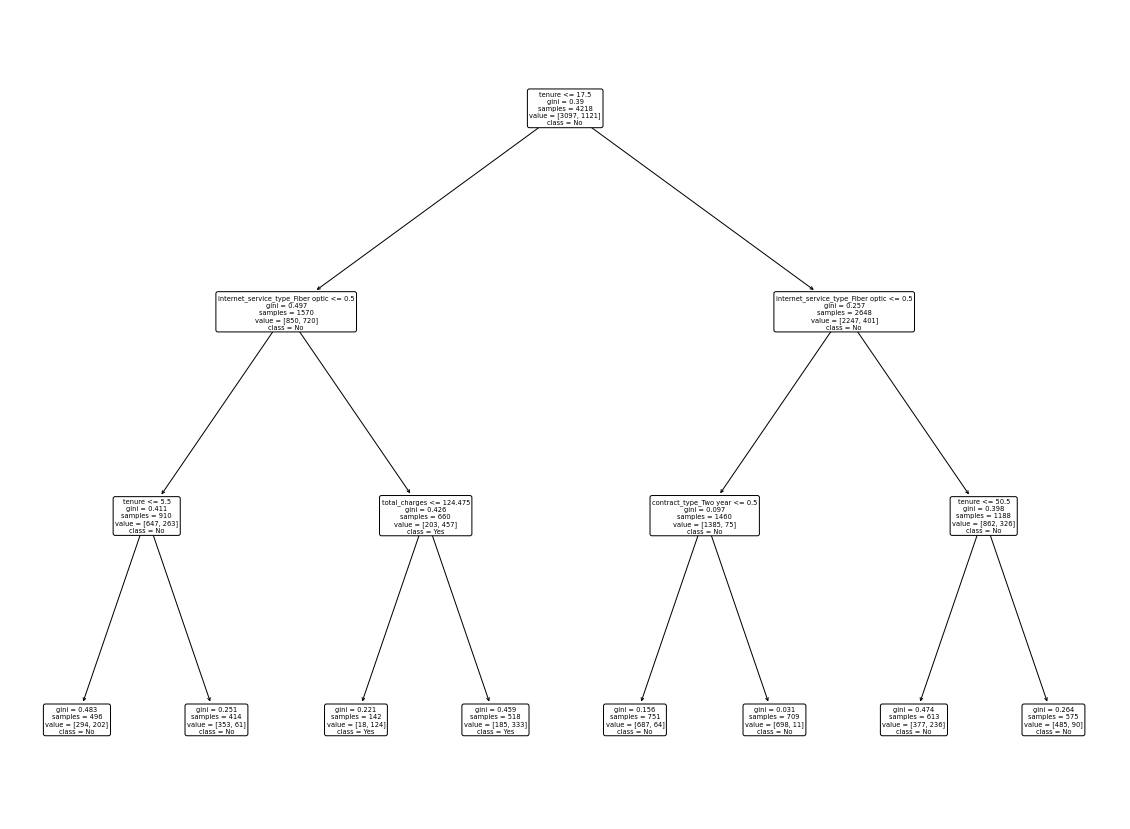

In [205]:
dt = DecisionTreeClassifier(max_depth=3, random_state = 123)
dt.fit(x_train,y_train)
y_pred= dt.predict(x_train)
print(classification_report(y_train, y_pred))


plt.figure(figsize=(20, 15))
plot_tree(dt, feature_names=x_train.columns, class_names=dt.classes_, rounded=True)



### k nearest neighbor

In [185]:
knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_train)

In [186]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

          No       0.83      0.95      0.89      3097
         Yes       0.78      0.46      0.58      1121

    accuracy                           0.82      4218
   macro avg       0.80      0.71      0.73      4218
weighted avg       0.82      0.82      0.81      4218



### looping through models

In [193]:
performance=[]
for i in range(1,21):
    model = RandomForestClassifier(min_samples_leaf=5, max_depth=(21-i), random_state=123)
    model = model.fit(x_train,y_train)
    in_sample_accuracy = model.score(x_train, y_train)
    out_of_sample_accuracy = model.score(x_validate, y_validate)
    output = {
        "max_depth": (21-i),
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    performance.append(output)
df = pd.DataFrame(performance)
df["difference"] = df.train_accuracy - df.validate_accuracy

In [197]:
df

,max_depth,train_accuracy,validate_accuracy,difference
0,20,0.856093,0.788202,0.067891
1,19,0.855856,0.787491,0.068365
2,18,0.856804,0.788913,0.067892
3,17,0.856093,0.788202,0.067891
4,16,0.855382,0.786780,0.068601
5,15,0.856330,0.784648,0.071682
6,14,0.851826,0.787491,0.064334
7,13,0.851826,0.781095,0.070731
8,12,0.851114,0.784648,0.066466
9,11,0.847558,0.793888,0.053670


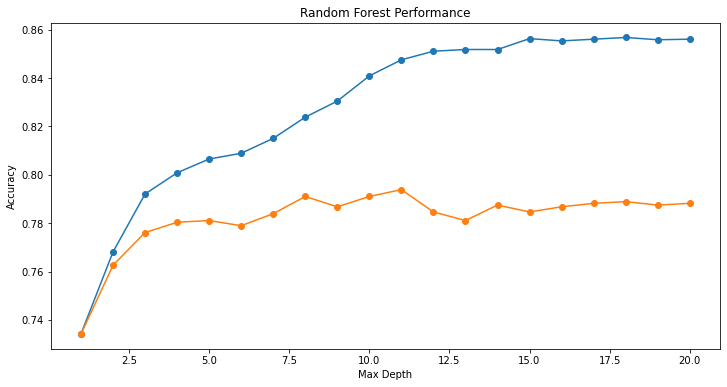

In [198]:

plt.figure(figsize=(12, 6))
plt.title('Random Forest Performance')
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [201]:
performance=[]
for i in range(1,21):
    model = KNeighborsClassifier(n_neighbors=i,weights='uniform')
    model = model.fit(x_train,y_train)
    in_sample_accuracy = model.score(x_train, y_train)
    out_of_sample_accuracy = model.score(x_validate, y_validate)
    output = {
        "max_depth": (21-i),
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    performance.append(output)
df = pd.DataFrame(performance)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,20,0.995495,0.713575,0.281921
1,19,0.861546,0.756219,0.105327
2,18,0.856093,0.740583,0.115510
3,17,0.829777,0.764037,0.065740
4,16,0.830251,0.756930,0.073322
5,15,0.821954,0.773276,0.048677
6,14,0.819109,0.778252,0.040857
7,13,0.811996,0.779673,0.032323
8,12,0.816738,0.777541,0.039197
9,11,0.810574,0.781805,0.028768


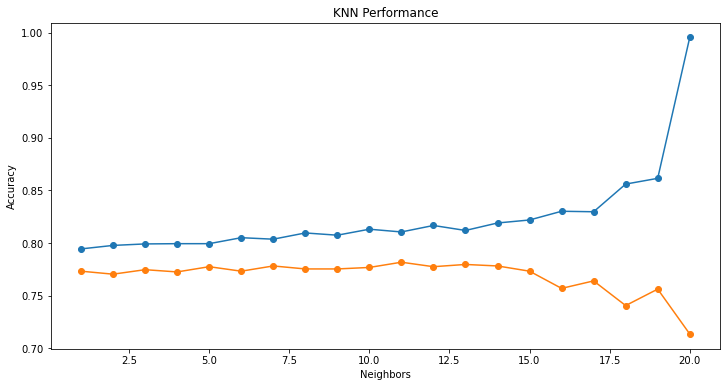

In [202]:

plt.figure(figsize=(12, 6))
plt.title('KNN Performance')
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Model Testing

The random forest model performed the best with min_samples_leaf set to 5 and max depth at 3

In [15]:
RF = RandomForestClassifier(min_samples_leaf=5, max_depth=3,random_state=123)
RF.fit(x_train,y_train)
y_pred = RF.predict(x_train)
print(RF.score(x_test,y_test))

0.7945984363894811
